## Prescription Opioid Model  
### Roland Chen, Noah Igra, Simon Zhao  
### November 20th, 2019

In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import csv
import math
import matplotlib.pyplot as plt



In [5]:
def parameter_plug(mycsv):
    '''Converts csv table of coefficients into a dictionary'''
    
    all_param = {}
    
    with open(mycsv,'r') as csv_file:
        data = csv.reader(csv_file, delimiter = ',')
        
        for line in data:
            #Make dictionary of values s.t the keys match the table key
            #inputformat is the proper format for such a table, but any order
            #of these specifically named parameters would work
            param = line[0]
            all_param[param] = float(line[1])
        
    return all_param

def progress_report(current_step,totalstep,howmanyreports):
    '''Returns a progress report a specified amount of times'''
    
    steps_per_report = totalstep//howmanyreports
    if current_step % steps_per_report == 0:
        report_percent = math.ceil((current_step / totalstep)*100)
        print('Progress: {}%'.format(report_percent))
        


def addict_initial(addictdeathrate,estaddictod,naturaldeath,presodrate2010,poprange):
    '''Calculates the proportion of the sample attributed to the addicted
    population at 2010'''
    
    #Based on Battista(2019) evaluation of addict pop at t0
    actual_pres_od_2010 = presodrate2010*poprange[2010]
    initialaddict = estaddictod*actual_pres_od_2010 / poprange[2010]
    initialaddict = initialaddict / (addictdeathrate - naturaldeath)
    
    return initialaddict


def addict_death_rate(estaddictod,actualod2015,naturaldeath,poprange):
    '''Calculates the death rate for the addicted population'''
    
    #Based on Battista(2019) evaluation of yearly addict death rate
    OP_SUD = 1.9/100 # northeast Opioid SUD proportion (Han 2015)
    addict_pop_2015 = poprange[2015] * OP_SUD
    addict_death = estaddictod * actualod2015 * poprange[2015]#2015
    addict_death = addict_death / addict_pop_2015
    addict_death = addict_death + (naturaldeath - estaddictod*actualod2015)
    rate = -1*math.log(1 - addict_death)
    
    return rate



# Model Validation

## **Step 1**: Input Parameters

In [14]:
param_dict = parameter_plug('nyc.csv')
#Depending on selection, will define our variable parameters accordingly

#Populations from 2010 - 2017
pop_2010_2017 = {2010:param_dict['pop_2010'],2011:param_dict['pop_2011'],
                 2012:param_dict['pop_2012'],2013:param_dict['pop_2013'],
                 2014:param_dict['pop_2014'],2015:param_dict['pop_2015'],
                 2016:param_dict['pop_2016'],2017:param_dict['pop_2017']}
est_addict_od = param_dict['est_addict_od']#Estimated proportion of prescription opioid overdoses attributed to addicts
#Actual overdoses from 2011-2017 and compiling those values into a list
opioid_od_2011 = param_dict['opioid_od_2011']*est_addict_od
opioid_od_2012 = param_dict['opioid_od_2012']*est_addict_od
opioid_od_2013 = param_dict['opioid_od_2013']*est_addict_od
opioid_od_2014 = param_dict['opioid_od_2014']*est_addict_od
opioid_od_2015 = param_dict['opioid_od_2015']*est_addict_od
opioid_od_2016 = param_dict['opioid_od_2016']*est_addict_od
opioid_od_2017 = param_dict['opioid_od_2017']*est_addict_od
addict_od_list = [opioid_od_2011,opioid_od_2012,opioid_od_2013,
                  opioid_od_2014,opioid_od_2015,opioid_od_2016,
                  opioid_od_2017]
od_dict = {2011:opioid_od_2011,2012:opioid_od_2012,2013:opioid_od_2013,
          2014:opioid_od_2014,2015:opioid_od_2015,2016:opioid_od_2016,
          2017:opioid_od_2017}
pres_rate = [param_dict['pres_rate']]#Prescription rate
no_addict_rate = [0.005,0.5,1.0,1.5,2.0,2.5,3]#Rate of ending prescription without addiction
treat_entry_rate = np.linspace(0.001,1,300,endpoint = True).tolist()#Treatment entry rate

addict_rate = param_dict['addict_rate']#Rate of addiction from prescription
addict_fromaddict_rate = param_dict['addict_fromaddict_rate']#Rate of addiction from illicit drugs from addicts 
addict_frompres_rate = param_dict['addict_frompres_rate']#Rate of addiction from illicit drugs from prescribed users 
relapse_rate = param_dict['relapse_rate']#Rate of relapse
rehab_success_rate = 0.1 #Rate of completing treatment successfully 


#Values to be used by all/ needed to evaluate initial conditions    
death_rate = param_dict['natural_death_rate']#Natural death rate
actual_od_death_2015 = param_dict['actual_od_death_2015']#Rate of actual overdose in 2015
presopioid_death_rate_2010 = param_dict['presopioid_death_rate_2010']#Rate of actual overdose in 2010
#Death rate attributed to the addicted class
addict_od_death_rate = addict_death_rate(est_addict_od,actual_od_death_2015,
                                             death_rate,pop_2010_2017)


step = 0 #initiate step_count
step_total = len(pres_rate)*len(treat_entry_rate)*len(no_addict_rate)*7 # Total iterations, not accounting for internal manipulations


In [15]:
t_0 = 2010
span = 8 #end at 2017
p_0 = param_dict['p_0']#Proportion of population prescribed opioids per week
a_0 = addict_initial(addict_od_death_rate,est_addict_od,death_rate,
                     presopioid_death_rate_2010,pop_2010_2017)
r_0 = 0.1*a_0
s_0 = 1 - (p_0 + a_0 + r_0)

###END OF DATA DUMP###

#Some opening notes, show user initial conditions
print('\nModeling epidemic starting at 2010:')
print('s = {:.4f}'.format(s_0))
print('p = {:.4f}'.format(p_0))
print('a = {:.4f}'.format(a_0))
print('r = {:.4f}'.format(r_0))


Modeling epidemic starting at 2010:
s = 0.9484
p = 0.0387
a = 0.0117
r = 0.0012


## Step 2: Solve the ODE's  

Define $\dot{S}$, $\dot{P}$, $\dot{A}$ , and $\dot{R}$

In [16]:
def func_s(t,x,s,p,a,r,addict_fromaddict_rate,addict_frompres_rate,
           j,rehab_success_rate,death_rate,addict_od_death_rate):
    '''returns RHS of ds/dt'''

    return -x*s -addict_fromaddict_rate*s*a -addict_frompres_rate*s*p + j*p + rehab_success_rate*r + death_rate*(p + r) + addict_od_death_rate*a
    
    
def func_p(t,x,s,p,j,addict_rate,death_rate):
    '''returns RHS of dp/dt'''

    return x*s -(j + addict_rate + death_rate)*p 
    

def func_a(t,addict_rate,s,p,a,r,relapse_rate,addict_fromaddict_rate,
           addict_frompres_rate,k,addict_od_death_rate):
    '''returns RHS of da/dt'''
    
    return addict_rate*p + relapse_rate*r + addict_fromaddict_rate*s*a + addict_frompres_rate*s*p -(k + addict_od_death_rate)*a
    


def func_r(t,k,a,r,rehab_success_rate,relapse_rate,death_rate):
    '''returns RHS of dr/dt'''

    return k*a -(rehab_success_rate + relapse_rate + death_rate)*r


### Combine above into a 4x1 function

In [17]:
def df_dt(t,poplist,x,j,k,addict_rate,addict_fromaddict_rate,
          addict_frompres_rate,relapse_rate,rehab_success_rate,
          addict_od_death_rate,death_rate):
    ''' returns RHS 4x1 matrix of ODE's  f(s), f(p), f(a), f(r)'''
    
    s,p,a,r = poplist[0], poplist[1], poplist[2],poplist[3]
    f_s = func_s(t,x,s,p,a,r,addict_fromaddict_rate,addict_frompres_rate,j,
                 rehab_success_rate,death_rate,addict_od_death_rate)
    f_p = func_p(t,x,s,p,j,addict_rate,death_rate)
    f_a = func_a(t,addict_rate,s,p,a,r,relapse_rate,addict_fromaddict_rate,
                 addict_frompres_rate,k,addict_od_death_rate)
    f_r = func_r(t,k,a,r,rehab_success_rate,relapse_rate,death_rate)
    return [f_s,f_p,f_a,f_r]


### RK4 solver for a 4x1 vector function

In [18]:
def rk4_odesolver(poplist,listofparameters):
    '''solves the 4-D ODE for the opioid epidemic for a step size of 1
    using the RK4 method using proportions at some t_n
    returns a tupple of our proportions at t_n+1'''
    
    #Local parameter assignement
    x = listofparameters[0]
    j = listofparameters[1]
    k = listofparameters[2]
    addict_rate = listofparameters[3]
    addict_fromaddict_rate = listofparameters[4]
    addict_frompres_rate = listofparameters[5]
    relapse_rate = listofparameters[6]
    rehab_success_rate = listofparameters[7]
    death_rate = listofparameters[8]
    addict_od_death_rate = listofparameters[9]

    #Some values for solveivp to be used for all populations
    method = 'RK45'
    atol = 1.e-10
    rtol = 1.e-6
    t_min = 0.
    t_max = 1
    t_span= np.array([t_min, t_max])
    
    
    pop_n_1 = solve_ivp(lambda t,poplist : 
        df_dt(t,poplist,x,j,k,addict_rate,addict_fromaddict_rate,
              addict_frompres_rate,relapse_rate,rehab_success_rate,
              addict_od_death_rate,death_rate),
       t_span,np.array(poplist),
       method = method, rtol=rtol, atol=atol,vectorized = True)

    values_n_1 = pop_n_1.y[:,-1]
    sfin,pfin,afin,rfin = values_n_1[0], values_n_1[1], values_n_1[2], values_n_1[3]

    return sfin,pfin,afin,rfin

### For each *combination* of parameters,  solve for span (t)

In [19]:
#Initiate list for results
results = []
step = 0
for pres_r in pres_rate: 
    for treat_ent_r in treat_entry_rate:
        for no_addict_r in no_addict_rate:
            #Reset proportions to t = t_0
            s,p,a,r = s_0, p_0, a_0, r_0

            #Compile all of our parameters into a list
            paramlist = [pres_r,no_addict_r,treat_ent_r,addict_rate,addict_fromaddict_rate,
                         addict_frompres_rate,relapse_rate,rehab_success_rate,
                         death_rate,addict_od_death_rate]

            #Calculate RK4 Steps for fixed set of parameters across span of time
            for year in range(t_0+1,(t_0 + span)):#For results in span from 2011
                #Setup lists to be used in rk4 solver
                pop_list = [s,p,a,r]
                #Find proportions for t0+1
                s_1,p_1,a_1,r_1 = rk4_odesolver(pop_list,paramlist)

                #Calculate S-ORD(t)
                od_death = (pop_2010_2017[year])*(addict_od_death_rate - death_rate)*a_1
                od_dif = abs(od_death - od_dict[year])#Compare to A-ORD(2017)
                results.append([year,pres_r,no_addict_r,treat_ent_r,
                                s_1,p_1,a_1,r_1,od_death,od_dif])


                #Return to vogue, assign initial conditions for next year
                s,p,a,r = s_1, p_1, a_1, r_1

                step = step + 1
                progress_report(step,step_total,3)


Progress: 34%
Progress: 67%
Progress: 100%


## Step 3: Visualize results

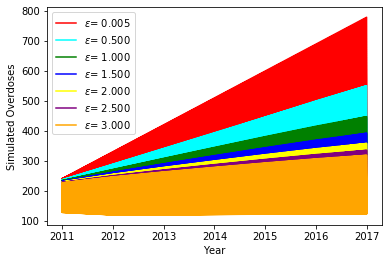

In [20]:
plot_array = np.array(results)
color_dict = {}
color_list = ['red','cyan','green','blue','yellow','purple','orange']
for i in range(len(no_addict_rate)):
    color_dict[no_addict_rate[i]] = color_list[i]
epsilon = '$\epsilon $'

for value in no_addict_rate:
    instance_plot = plot_array[plot_array[:,2] == value]
    instance_x = instance_plot[:,0]
    instance_y = instance_plot[:,8]
    instance_key = '= {:.3f}'.format(value)
    instance_label = epsilon + instance_key
    plt.plot(instance_x,instance_y, 
             label = instance_label, 
             color = color_dict[value])  
plt.xlabel('Year')
plt.ylabel('Simulated Overdoses')
plt.legend()
plt.show()

# Redefined System Validation

In [21]:
def g_s(t,x,s,p,a,r,f,g,
           j,relapse_rate,death_rate,addict_od_death_rate):
    
    return -(x+a+p)*s + (j+death_rate)*p/f + x*((1/relapse_rate)-1)*r + addict_od_death_rate*a/g

def g_p(t,x,s,p,f,j,addict_rate,death_rate):
    
    return x*f*s - (j + addict_rate + death_rate)*p

def g_a(t,addict_rate,s,p,a,r,x,relapse_rate,f,
           g,h,k,addict_od_death_rate):
    
    return x*g*r + (h*addict_rate + g*s)*p + (g*s - (k + addict_od_death_rate))*a

def g_r(t,k,a,r,x,g,relapse_rate,death_rate):
    
    return k*relapse_rate*a/(x*g) - r

def dg_dt(t,poplist,x,j,k,addict_rate,f,
          g,h,relapse_rate,
          addict_od_death_rate,death_rate):
    s,p,a,r = poplist[0], poplist[1], poplist[2],poplist[3]
    
    gs = g_s(t,x,s,p,a,r,f,g,j,relapse_rate,death_rate,
             addict_od_death_rate)
    gp = g_p(t,x,s,p,f,j,addict_rate,death_rate)
    ga = g_a(t,addict_rate,s,p,a,r,x,relapse_rate,f,
           g,h,k,addict_od_death_rate)
    gr = g_r(t,k,a,r,x,g,relapse_rate,death_rate)
    
    return [gs,gp,ga,gr]


In [22]:
def new_rk4_odesolver(poplist,listofparameters):
    #Local parameter assignement
    x = listofparameters[0]
    j = listofparameters[1]
    k = listofparameters[2]
    addict_rate = listofparameters[3]
    addict_fromaddict_rate = listofparameters[4]
    addict_frompres_rate = listofparameters[5]
    relapse_rate = listofparameters[6]
    rehab_success_rate = listofparameters[7]
    death_rate = listofparameters[8]
    addict_od_death_rate = listofparameters[9]

    #Some values for solveivp to be used for all populations
    method = 'RK45'
    atol = 1.e-10
    rtol = 1.e-6
    t_min = 0.
    t_max = 1
    t_span= np.array([t_min, t_max])
    
    
    poplist[0] = poplist[0]*x
    poplist[3] = poplist[3]*relapse_rate

    f = addict_frompres_rate/x
    h = addict_fromaddict_rate/addict_frompres_rate
    g = addict_fromaddict_rate/x

    poplist[1] = poplist[1]*x*f
    poplist[2] = poplist[2]*x*h*f

    pop_n_1 = solve_ivp(lambda t,poplist : 
        dg_dt(t,poplist,x,j,k,addict_rate,f,g,h,relapse_rate,
              addict_od_death_rate,death_rate),
        t_span,np.array(poplist),
        method = method, rtol=rtol, atol=atol,vectorized = True)

    values_n_1 = pop_n_1.y[:,-1]
    sfin,pfin,afin,rfin = values_n_1[0], values_n_1[1], values_n_1[2], values_n_1[3]

    sfin = sfin/x
    pfin = pfin/(x*f)
    afin = afin/(x*h*f)
    rfin = rfin/relapse_rate



    return sfin,pfin,afin,rfin


In [23]:
#Initiate list for results
new_results = []
step = 0
for x in pres_rate: 
    for k in treat_entry_rate:
        for j in no_addict_rate:
            #Reset proportions to t = t_0
            s,p,a,r = s_0, p_0, a_0, r_0

            #Compile all of our parameters into a list
            paramlist = [x,j,k,addict_rate,addict_fromaddict_rate,
                         addict_frompres_rate,relapse_rate,rehab_success_rate,
                         death_rate,addict_od_death_rate]

            #Calculate RK4 Steps for fixed set of parameters across span of time
            for year in range(t_0+1,(t_0 + span)):#For results in span from 2011
                #Setup lists to be used in rk4 solver
                pop_list = [s,p,a,r]
                #Find proportions for t0+1
                s_1,p_1,a_1,r_1 = new_rk4_odesolver(pop_list,paramlist)

                #Calculate S-ORD(t)
                od_death = (pop_2010_2017[year])*(addict_od_death_rate - death_rate)*a_1
                if i == 2017: #For 1 and 2, only care about difference at end
                    od_dif = abs(od_death - opioid_od_2017)#Compare to A-ORD(2017)
                    new_results.append([year,x,j,k,s_1,p_1,a_1,r_1,od_death,od_dif])
                else:
                    new_results.append([year,x,j,k,s_1,p_1,a_1,r_1,od_death,0])

                #Return to vogue, assign initial conditions for next year
                s,p,a,r = s_1, p_1, a_1, r_1

                step = step + 1
                progress_report(step,step_total,3)

Progress: 34%
Progress: 67%
Progress: 100%


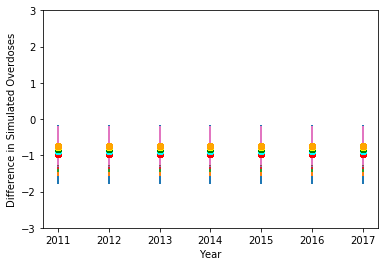

In [24]:
new_plot_array = np.array(new_results)
color_dict = {}
color_list = ['red','cyan','green','blue','yellow','purple','orange']
for i in range(len(no_addict_rate)):
    color_dict[no_addict_rate[i]] = color_list[i]
epsilon = '$\epsilon $'

for value in no_addict_rate:
    instance_plot = plot_array[plot_array[:,2] == value]
    instance_plot_new = new_plot_array[new_plot_array[:,2] == value]
    instance_x = instance_plot[:,0]
    instance_y = np.mean((instance_plot[:,8] - instance_plot_new[:,8]))
    instance_y = instance_y*np.ones([instance_x.shape[0],1])
    instance_y_std = np.std((instance_plot[:,8] - instance_plot_new[:,8]))
    instace_y_std = instance_y_std*np.ones([instance_x.shape[0],1])
    instance_key = '= {:.3f}'.format(value)
    instance_label = epsilon + instance_key
    plt.plot(instance_x,instance_y,'o', 
             label = instance_label, 
             color = color_dict[value]) 
    plt.errorbar(instance_x,instance_y, yerr = instance_y_std, xerr = None,fmt = 'none')
plt.xlabel('Year')
plt.ylabel('Difference in Simulated Overdoses')
plt.ylim(-3,3)
plt.show()